In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import scipy.sparse as sp
import yaml
import time
import gget
import pickle
from scipy.spatial.distance import cdist
import scipy
from scipy.stats import zscore
from tqdm import tqdm
from statsmodels.stats.multitest import multipletests
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from adjustText import adjust_text

import anndata as an
import scanpy as sc
import scanpy.external as sce
import rapids_singlecell as rsc
import scvi

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import linregress

import cupy as cp
from cuml.manifold import TSNE
from cuml.decomposition import PCA

sc.settings.verbosity = 3

# Load in data

In [2]:
%%time
fpath = "/scratch/indikar_root/indikar1/shared_data/hematokytos/new_processed/fib_ihsc_processed.h5ad"
adata = sc.read_h5ad(fpath)
adata

CPU times: user 856 ms, sys: 2.19 s, total: 3.05 s
Wall time: 14.3 s


AnnData object with n_obs × n_vars = 15317 × 23434
    obs: 'batch', 'barcoded_phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'S_score', 'G2M_score', 'phase', 'leiden', 'cluster_str'
    var: 'gene_id', 'gene_type', 'Chromosome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'batch_colors', 'cluster_str_colors', 'draw_graph', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 

In [3]:
adata.obs['batch'].value_counts()

batch
hsc    8357
fib    6960
Name: count, dtype: int64

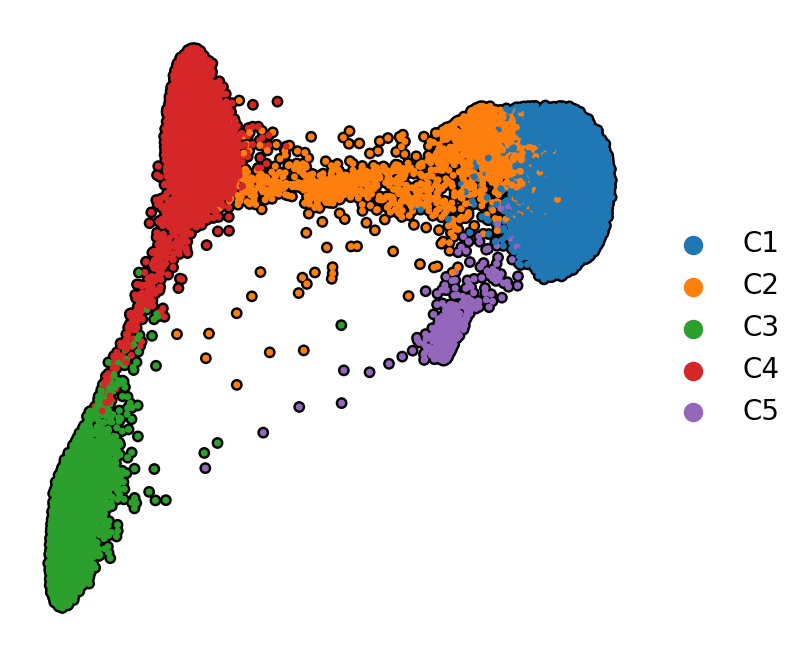

In [4]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

sc.pl.draw_graph(
    adata, 
    color=['cluster_str'],
    size=25,
    ncols=3,
    alpha=1,
    use_raw=False,
    add_outline=True,
    outline_color=('k', 'k'),
    title="",
    frameon=False,
    wspace=0.5,
)

# Score cell cycle genes

In [5]:
regev_genes = [x.strip() for x in open('/home/jrcwycy/githubrepositories/hybrid_reprogramming/resources/regev_lab_cell_cycle_genes.txt')]
s_genes = regev_genes[:43]
g2m_genes = regev_genes[43:]

sc.tl.score_genes_cell_cycle(
    adata,
    s_genes=s_genes,
    g2m_genes=g2m_genes,
    layer='log_norm',   
)

adata.obs[['phase']].head()

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    472 total control genes are used. (0:00:01)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    384 total control genes are used. (0:00:02)
-->     'phase', cell cycle phase (adata.obs)


phase
AAACCCAAGGTTACCT-1_hsc    G1
AAACCCAAGTTGAAGT-1_hsc    G1
AAACCCAAGTTGTCGT-1_hsc     S
AAACCCACAGAAGCGT-1_hsc    G1
AAACCCACAGGAGGTT-1_hsc    G1

... storing 'phase' as categorical


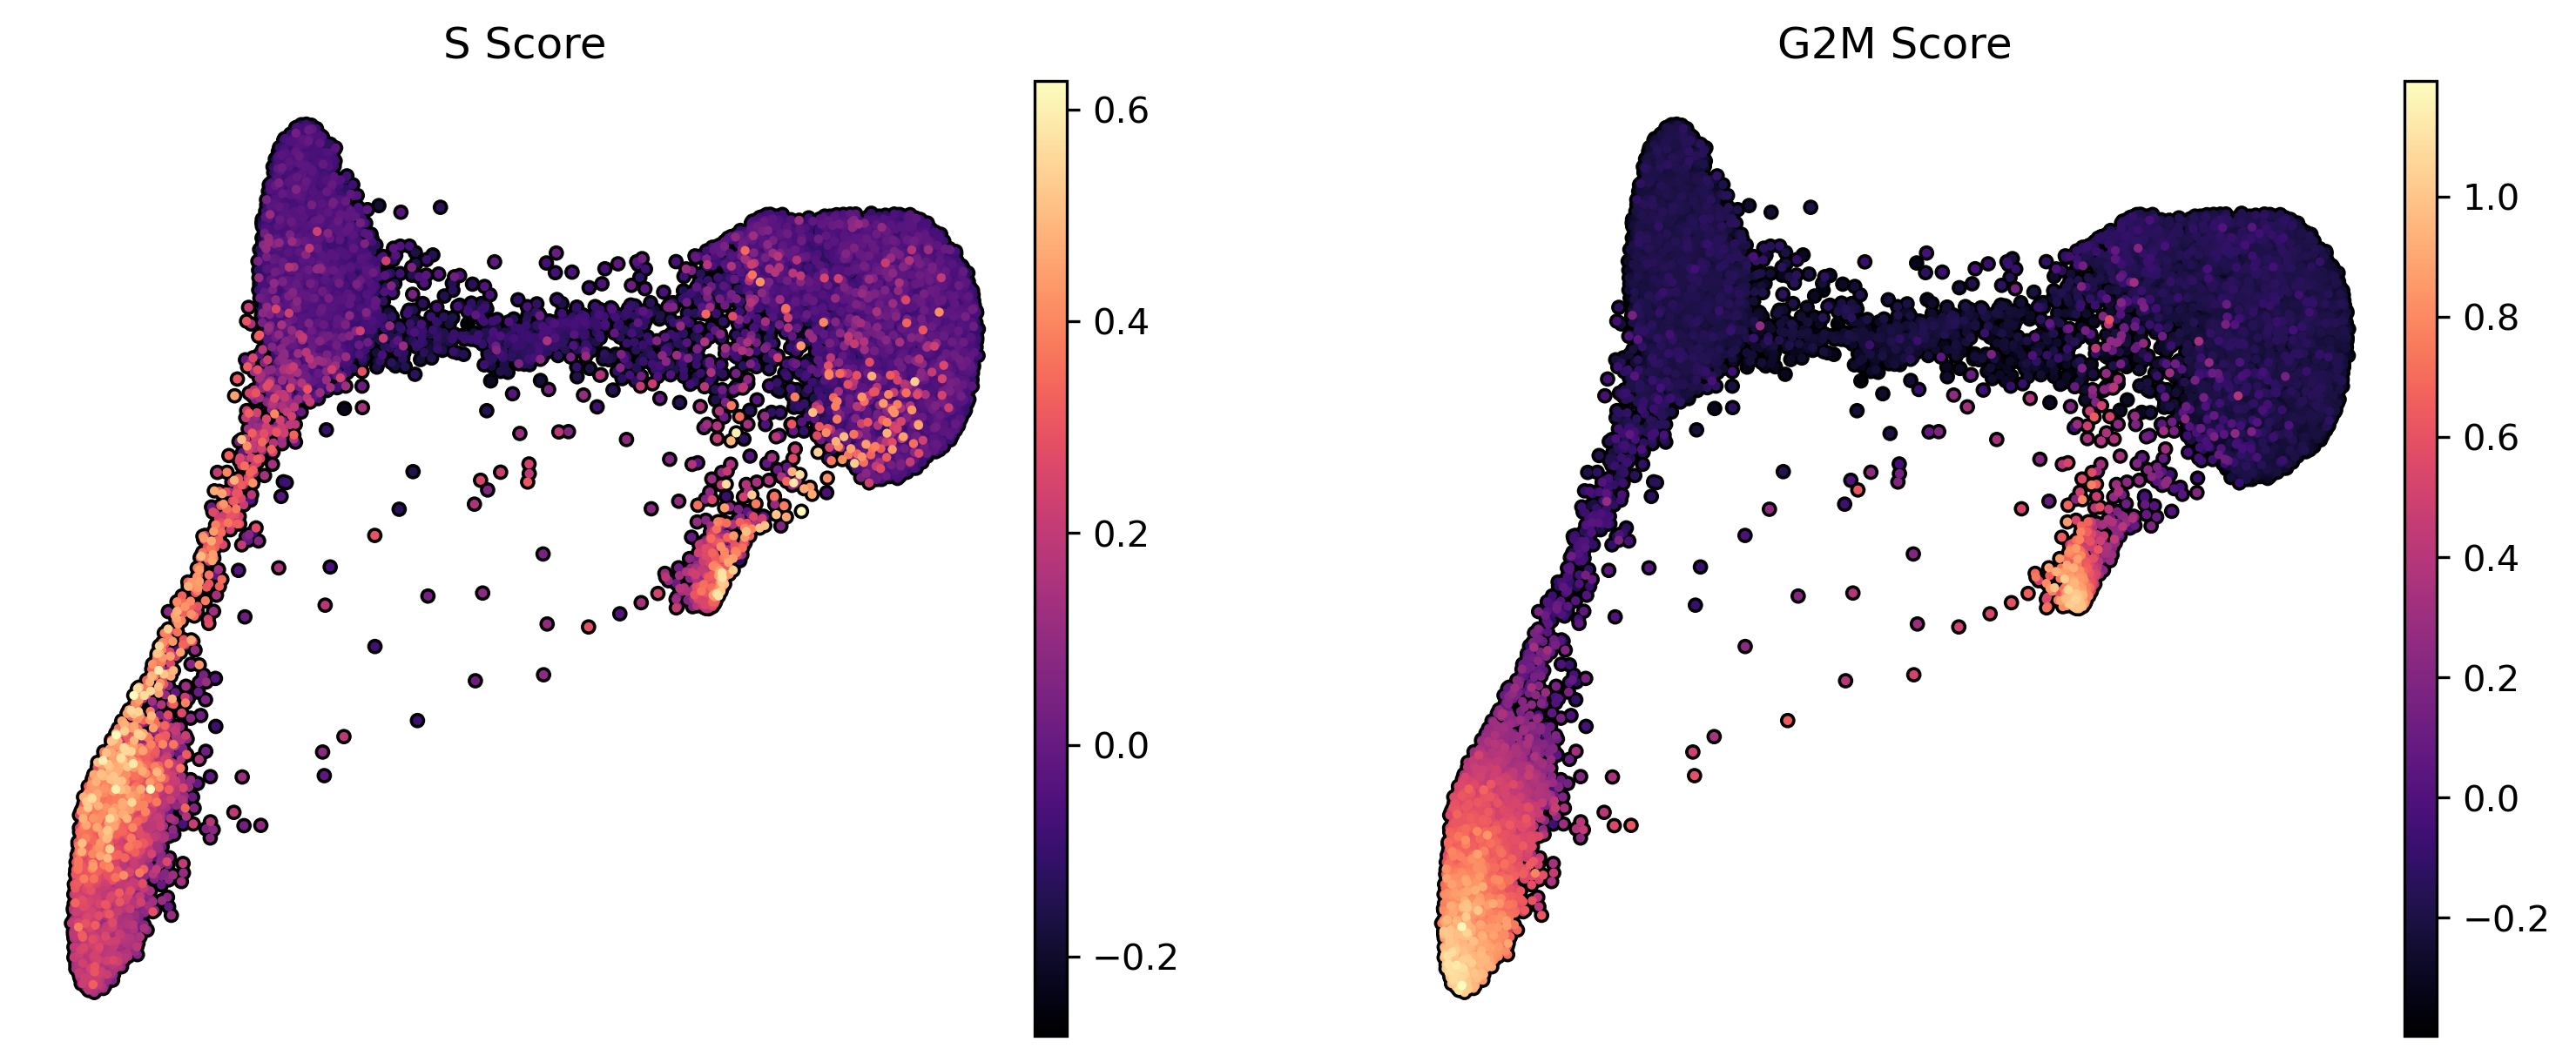

In [6]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4.75, 4.75

sc.pl.draw_graph(
    adata, 
    # mask_obs=(adata.obs['batch'] == 'fib'),
    color=['S_score', 'G2M_score',],
    size=25,
    ncols=3,
    alpha=1,
    use_raw=False,
    add_outline=True,
    na_in_legend=False,
    cmap='magma',
    outline_color=('k', 'k'),
    title=['S Score', 'G2M Score'],
    frameon=False,
    wspace=0.25,
)

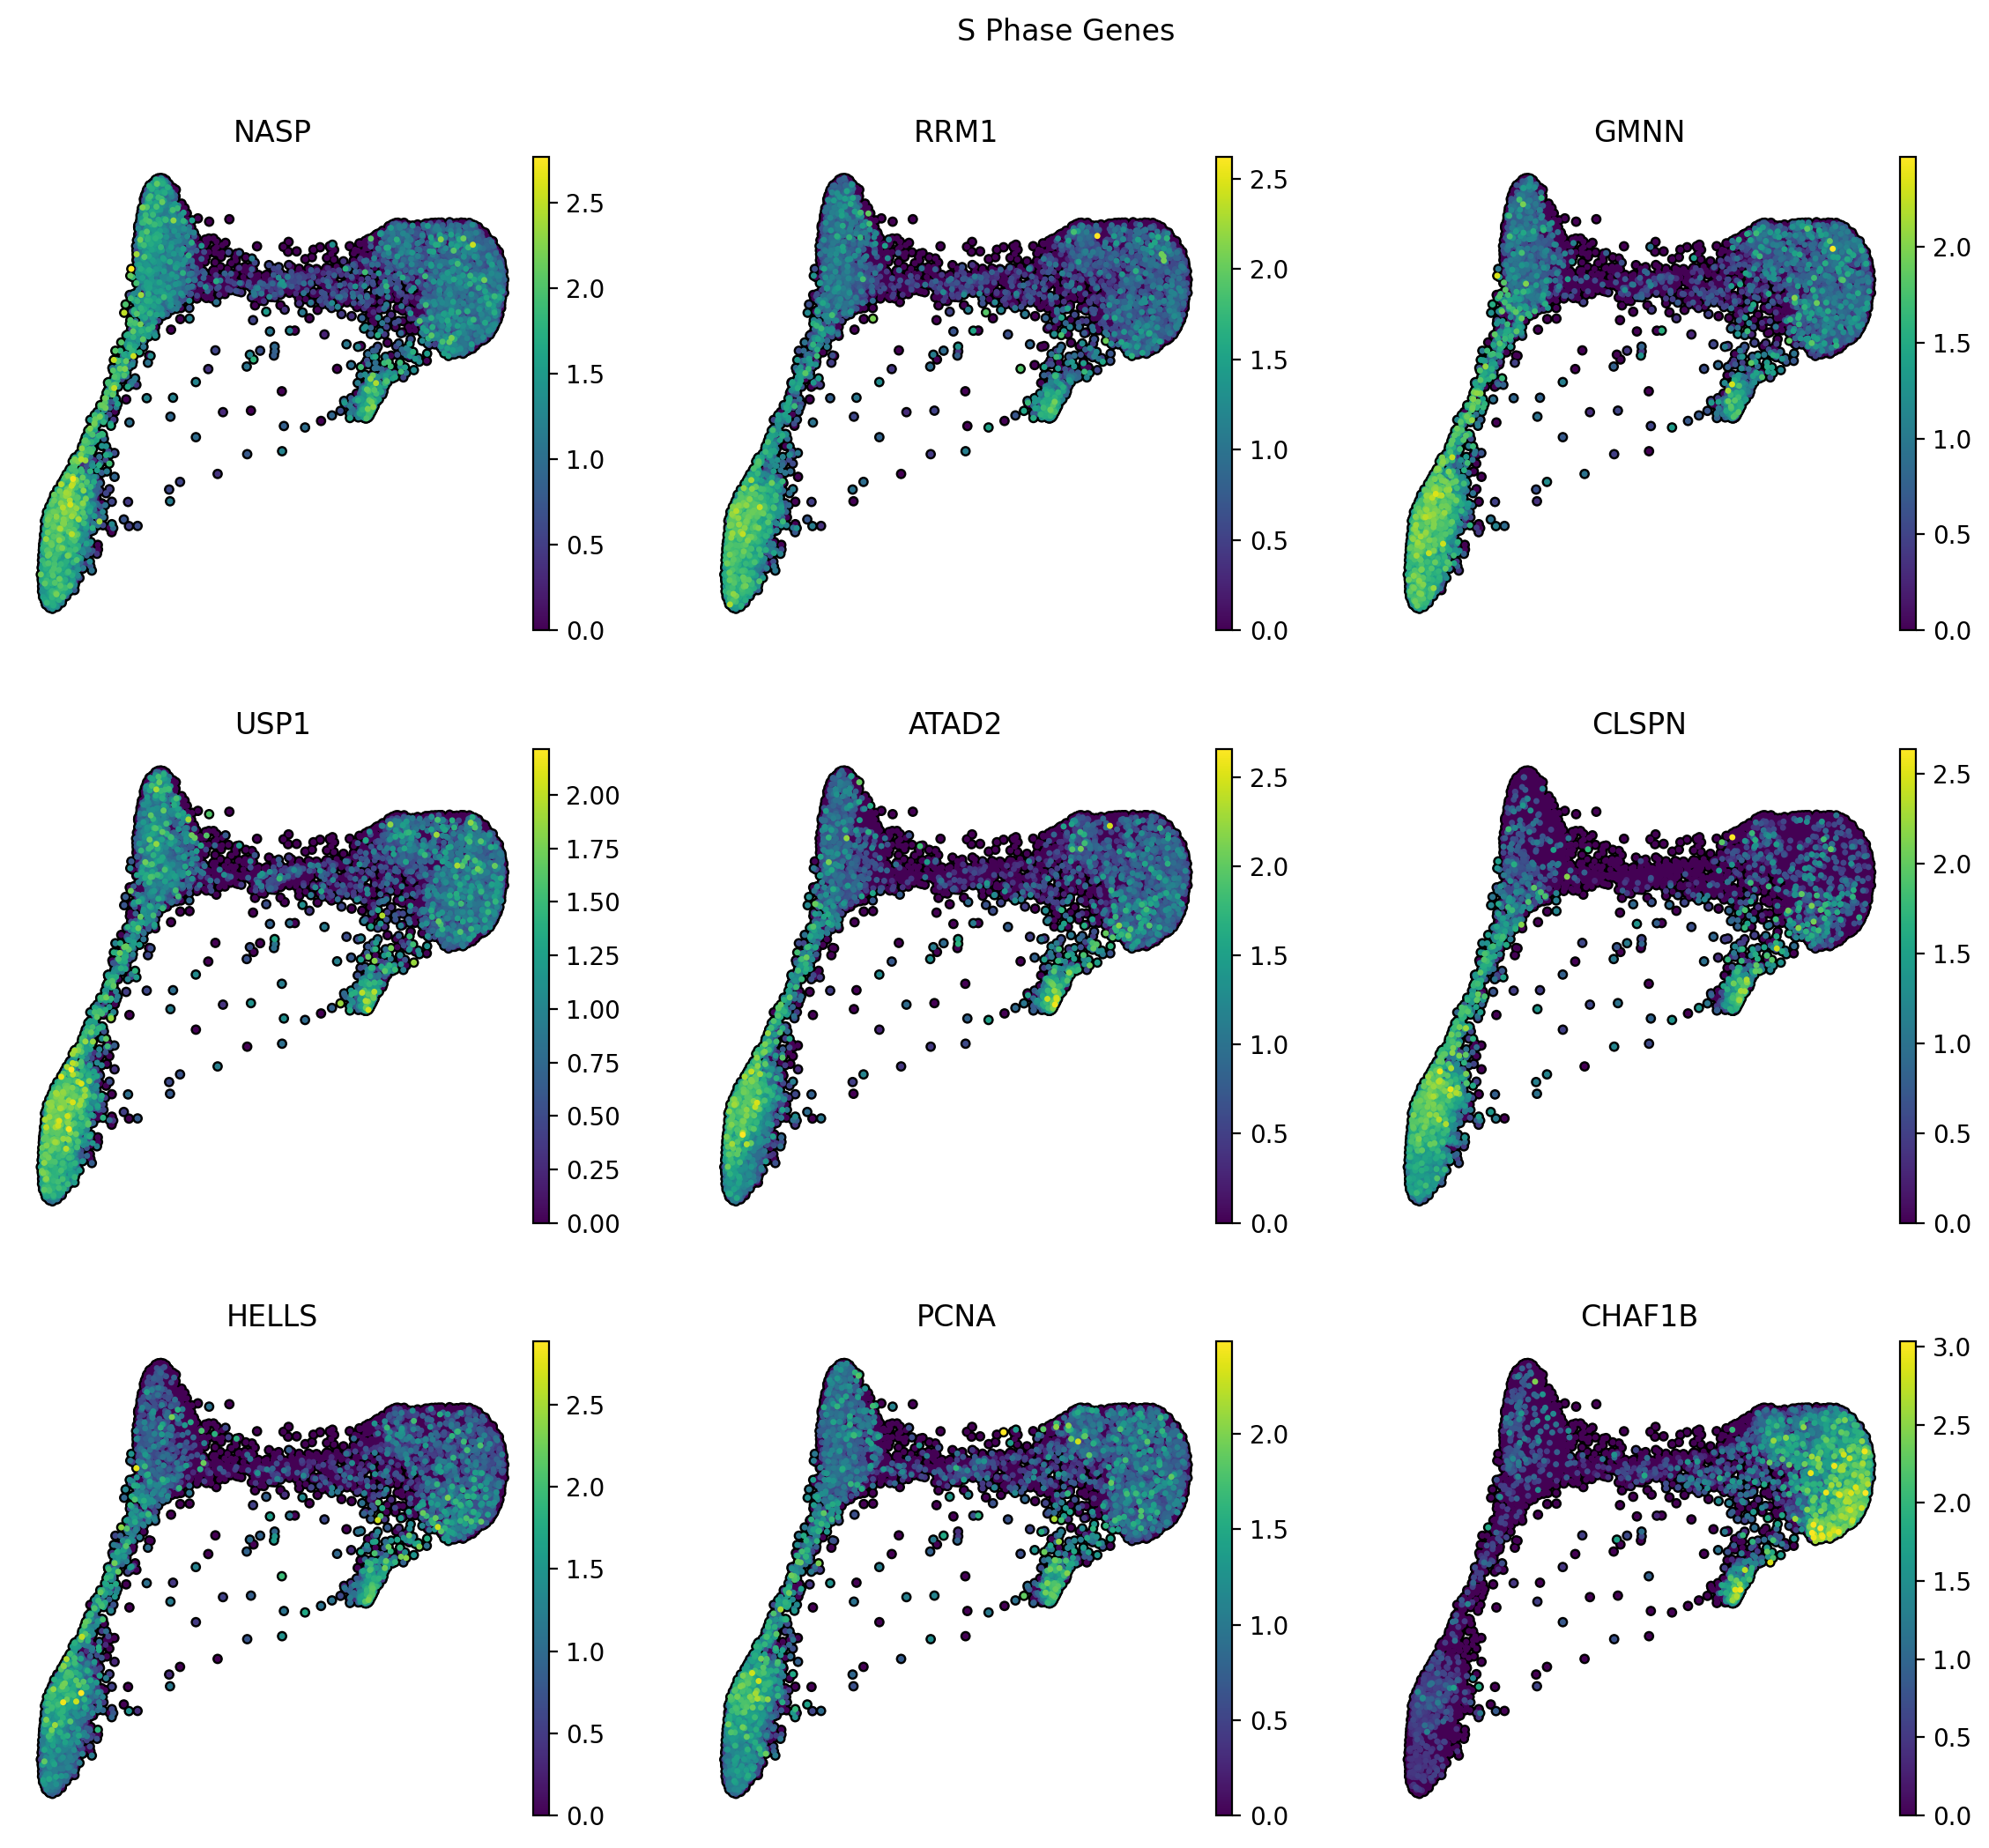

In [7]:
# get higest expressed S phase genes
adata.X = adata.layers['log_norm'].copy()

s_genes = [g for g in s_genes if g in adata.var_names]

mean_expr = adata[:, s_genes].X.mean(axis=0).A1  
top9_genes = [s_genes[i] for i in mean_expr.argsort()[::-1][:9]]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.75, 3.75

fig = sc.pl.draw_graph(
    adata, 
    color=top9_genes,
    size=25,
    ncols=3,
    alpha=1,
    use_raw=False,
    add_outline=True,
    na_in_legend=False,
    # colorbar_loc=None,
    outline_color=('k', 'k'),
    frameon=False,
    show=False, 
    return_fig=True,  
)

fig.suptitle("S Phase Genes", y=0.95)
plt.show()

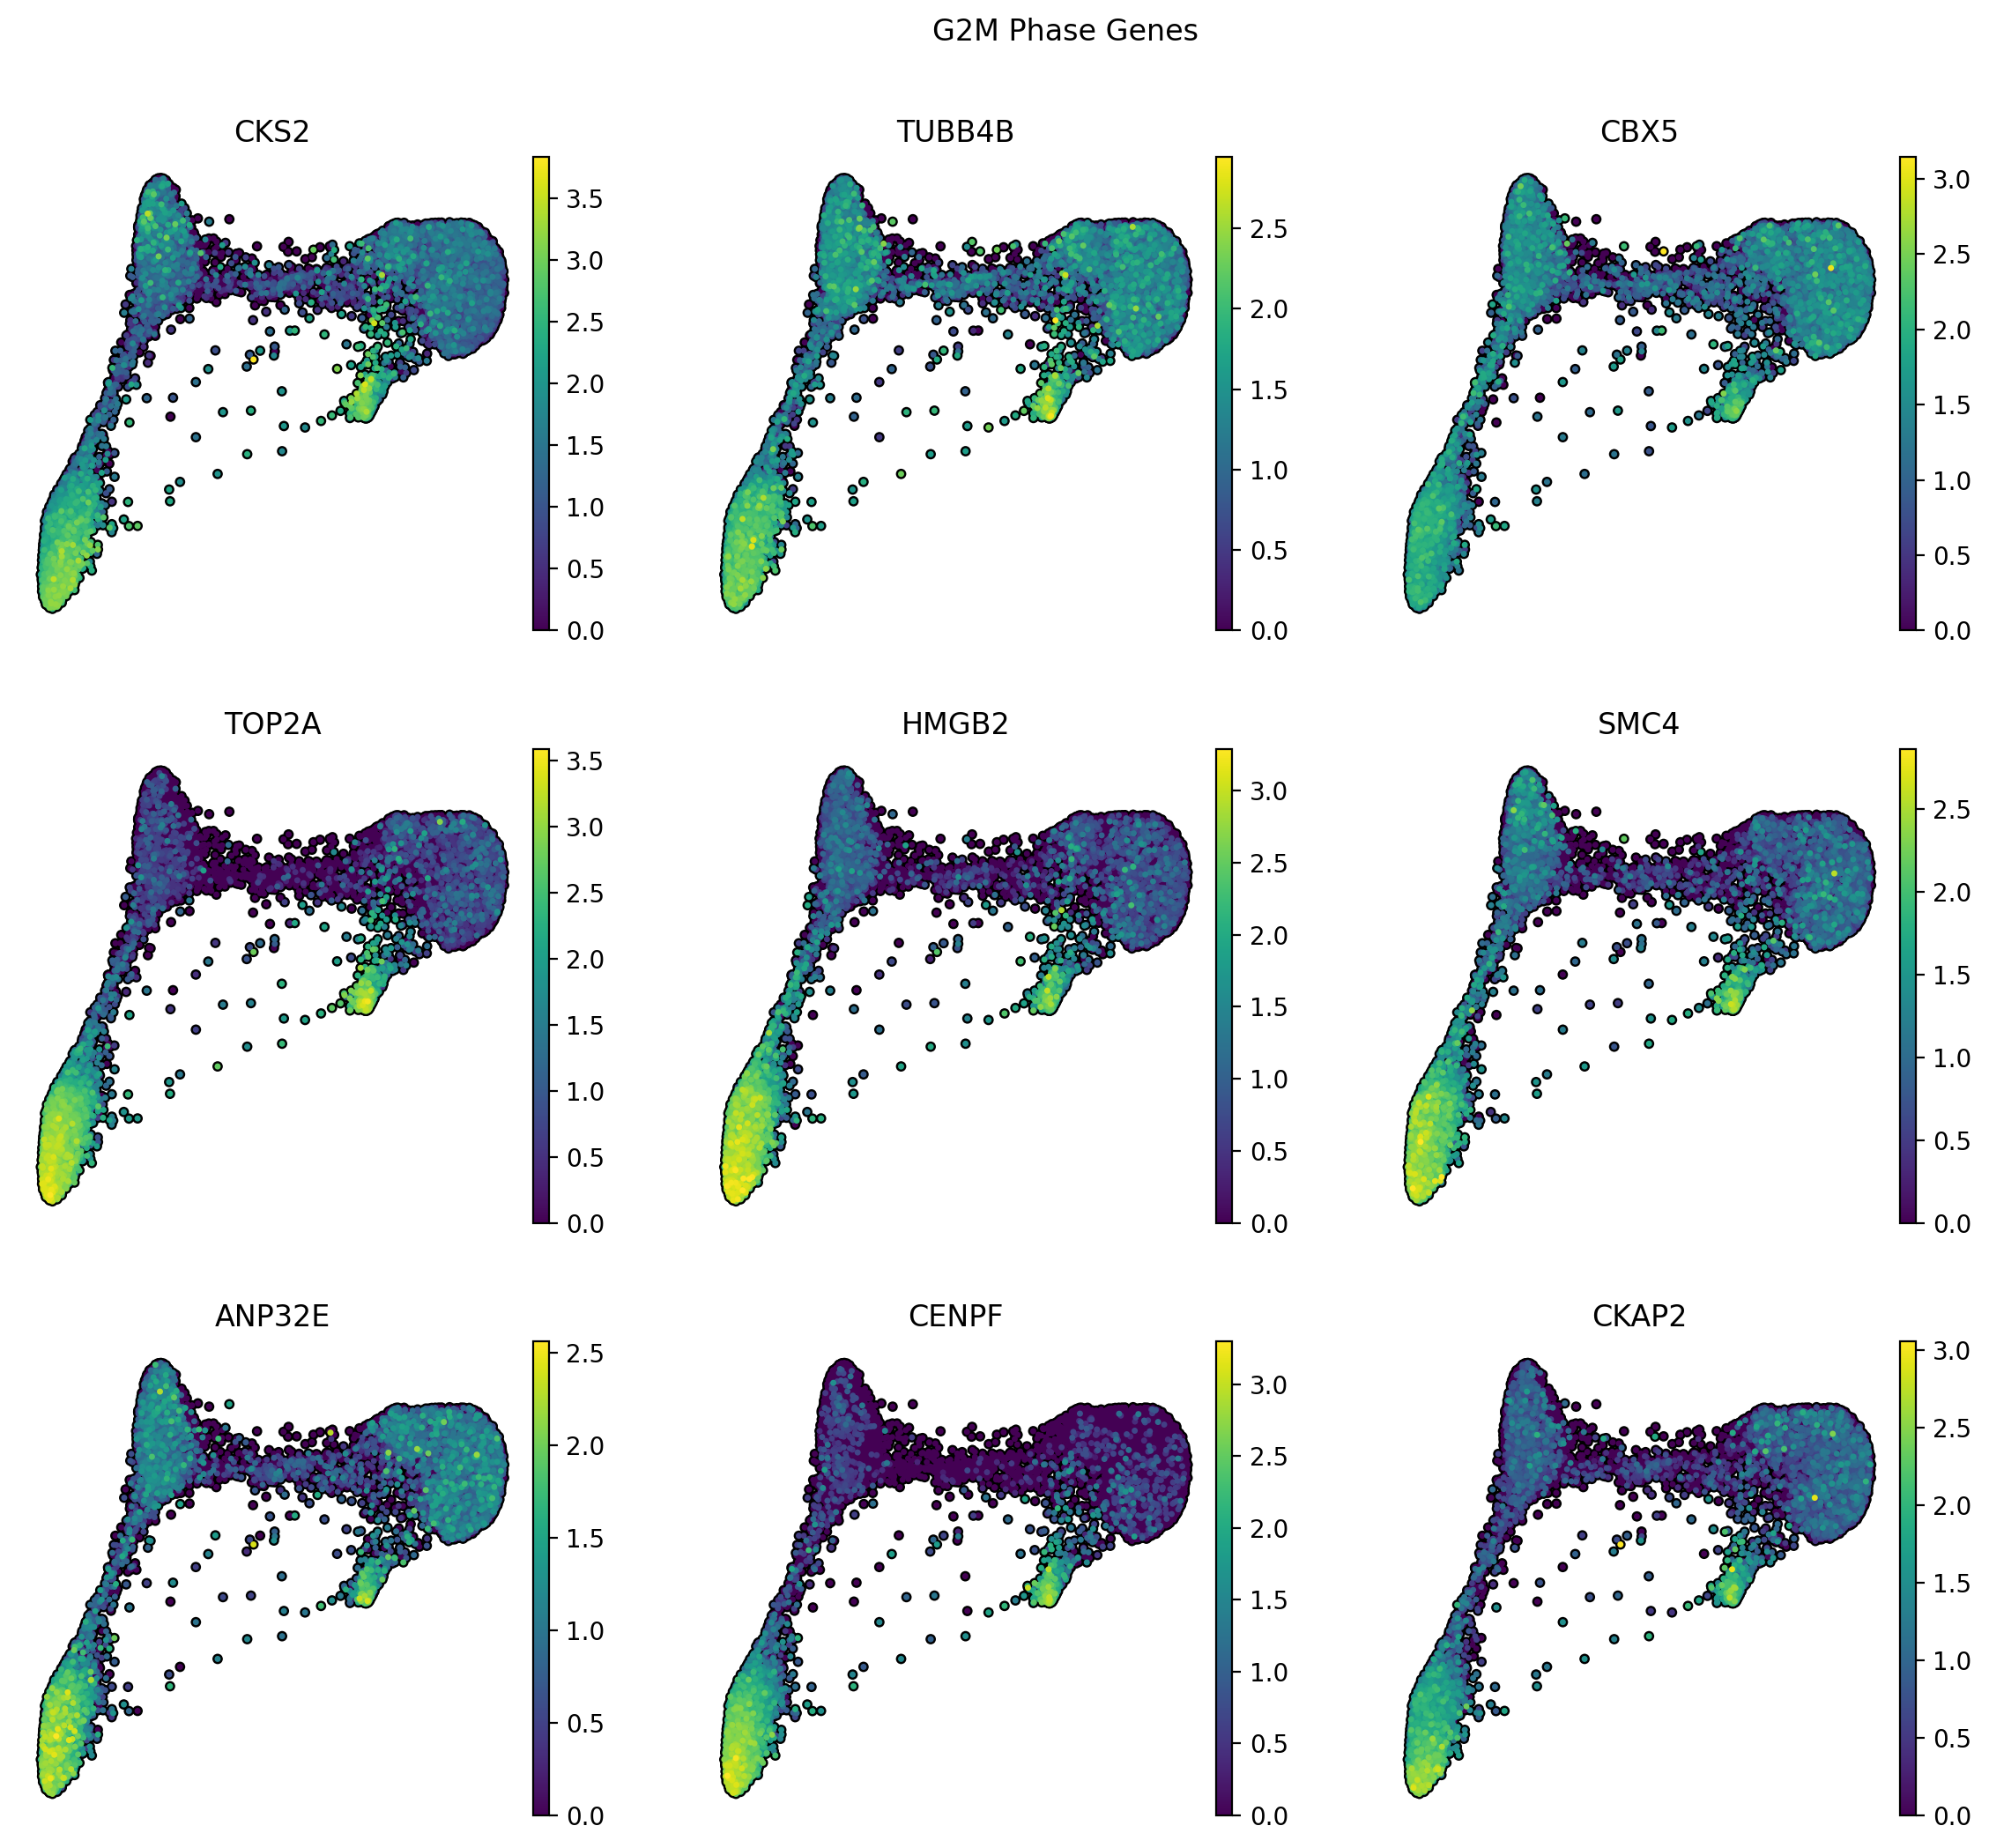

In [8]:
# get higest expressed G2M phase genes

g2m_genes = [g for g in g2m_genes if g in adata.var_names]

mean_expr = adata[:, g2m_genes].X.mean(axis=0).A1  
top9_genes = [g2m_genes[i] for i in mean_expr.argsort()[::-1][:9]]

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.75, 3.75

fig = sc.pl.draw_graph(
    adata, 
    color=top9_genes,
    size=25,
    ncols=3,
    alpha=1,
    use_raw=False,
    add_outline=True,
    na_in_legend=False,
    # colorbar_loc=None,
    outline_color=('k', 'k'),
    frameon=False,
    show=False, 
    return_fig=True,  
)

fig.suptitle("G2M Phase Genes", y=0.95)
plt.show()